<a href="https://colab.research.google.com/github/SainavyaGadde/LLMTUNING/blob/main/LLMtuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Performing Exploratory Data Analysis...


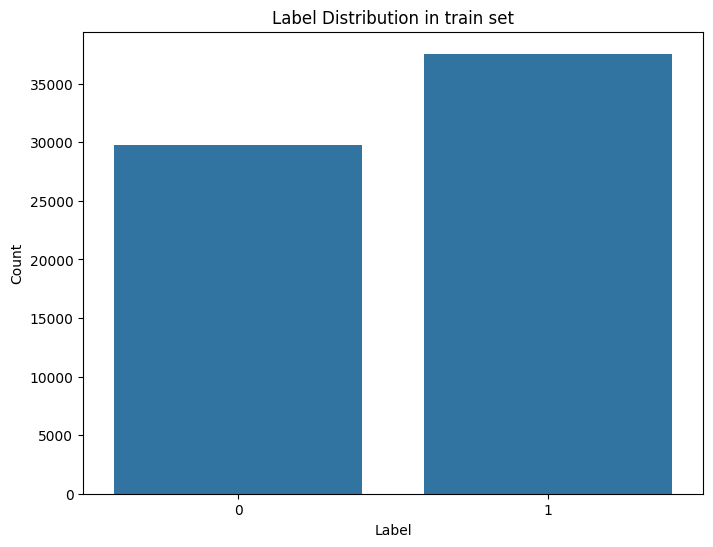

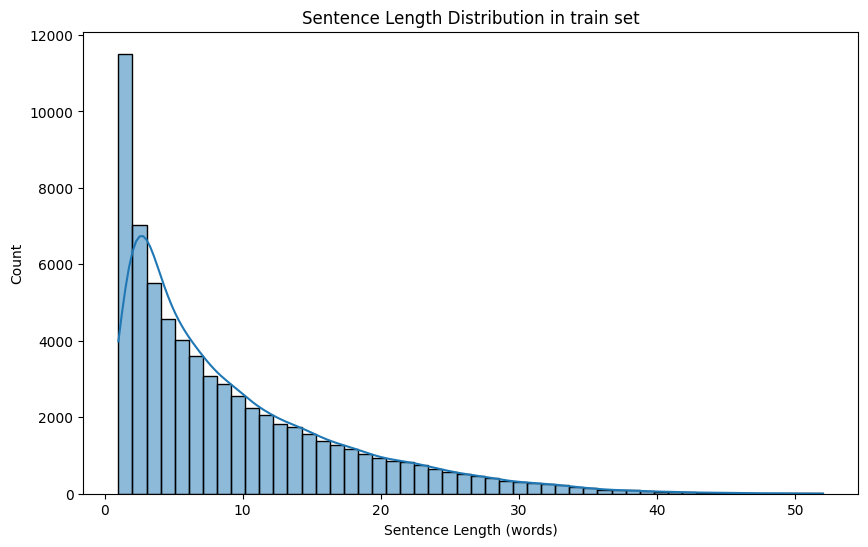

Sentence: klein , charming in comedies like american pie and dead-on in election , 
Label: Positive

Sentence: be fruitful 
Label: Positive

Sentence: soulful and 
Label: Positive

Sentence: the proud warrior that still lingers in the souls of these characters 
Label: Positive

Sentence: covered earlier and much better 
Label: Negative



In [ ]:
# EDA Functions
def plot_label_distribution(dataset, split):
    labels = dataset[split]['label']
    plt.figure(figsize=(8, 6))
    sns.countplot(x=labels)
    plt.title(f'Label Distribution in {split} set')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

def plot_sentence_length_distribution(dataset, split):
    sentences = dataset[split]['sentence']
    lengths = [len(sentence.split()) for sentence in sentences]
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, kde=True, bins=50)
    plt.title(f'Sentence Length Distribution in {split} set')
    plt.xlabel('Sentence Length (words)')
    plt.ylabel('Count')
    plt.show()

def print_random_samples(dataset, split, n=5):
    samples = dataset[split].shuffle(seed=42).select(range(n))
    for sample in samples:
        print(f"Sentence: {sample['sentence']}")
        print(f"Label: {'Positive' if sample['label'] == 1 else 'Negative'}")
        print()

# Perform EDA
print("Performing Exploratory Data Analysis...")
plot_label_distribution(dataset, 'train')
plot_sentence_length_distribution(dataset, 'train')
print_random_samples(dataset, 'train')

In [ ]:

# Load pre-trained DistilBERT tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare dataset for training
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Split the dataset
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(500))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
# Define metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print("Training the model...")
trainer.train()

# Evaluate the model
print("Evaluating the model...")
eval_results = trainer.evaluate()
print(eval_results)

Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.342600,0.298010,0.886000,0.886228,0.925000,0.850575
2,0.198300,0.323729,0.858000,0.862669,0.871094,0.854406


Evaluating the model...


{'eval_loss': 0.3237287402153015, 'eval_accuracy': 0.858, 'eval_f1': 0.862669245647969, 'eval_precision': 0.87109375, 'eval_recall': 0.8544061302681992, 'eval_runtime': 7.533, 'eval_samples_per_second': 66.375, 'eval_steps_per_second': 1.062, 'epoch': 2.0}


In [ ]:
# Save the model and tokenizer
model_path = "./sentiment_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Load the saved model and tokenizer for prediction
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:

# Function to predict sentiment of new sentences
def predict_sentiment(sentence):
    inputs = loaded_tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probs, dim=-1).item()
    return "Positive" if prediction == 1 else "Negative"

# Test the model on a new sentence
new_sentence = "This movie was a delightful experience from start to finish."
print(f"Sentence: {new_sentence}")
print(f"Sentiment: {predict_sentiment(new_sentence)}")

# Function to get predictions for the entire dataset
def get_predictions(dataset):
    predictions = []
    for batch in tqdm(dataset, desc="Getting predictions"):
        inputs = {k: v.to(loaded_model.device) for k, v in batch.items() if k != 'labels'}
        with torch.no_grad():
            outputs = loaded_model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions.extend(preds)
    return np.array(predictions)

# Get predictions for the evaluation dataset
print("Getting predictions for the evaluation dataset...")
eval_preds = get_predictions(eval_dataset)
eval_labels = np.array(eval_dataset['labels'])

Sentence: This movie was a delightful experience from start to finish.
Sentiment: Positive
Getting predictions for the evaluation dataset...


Getting predictions: 100%|██████████| 500/500 [05:54<00:00,  1.41it/s]


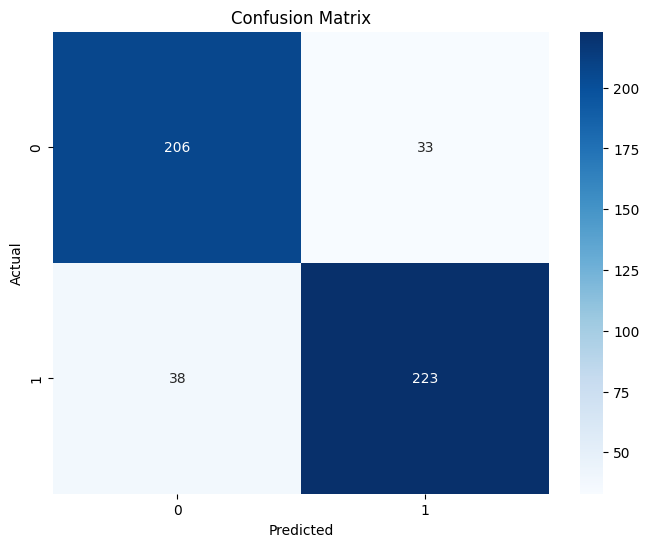


Detailed Evaluation Metrics:
Accuracy: 0.8580
Precision: [0.8442623  0.87109375]
Recall: [0.86192469 0.85440613]
F1-score: [0.85300207 0.86266925]

Error Analysis:
Total errors: 71


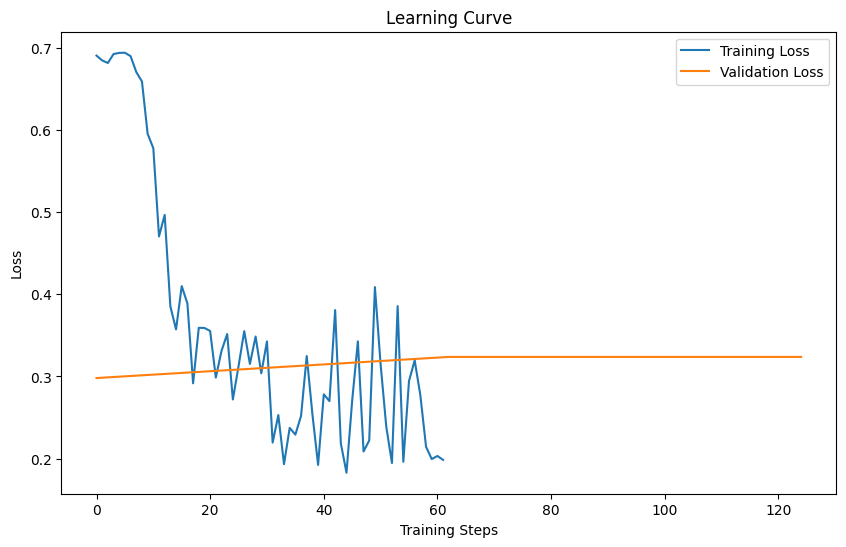

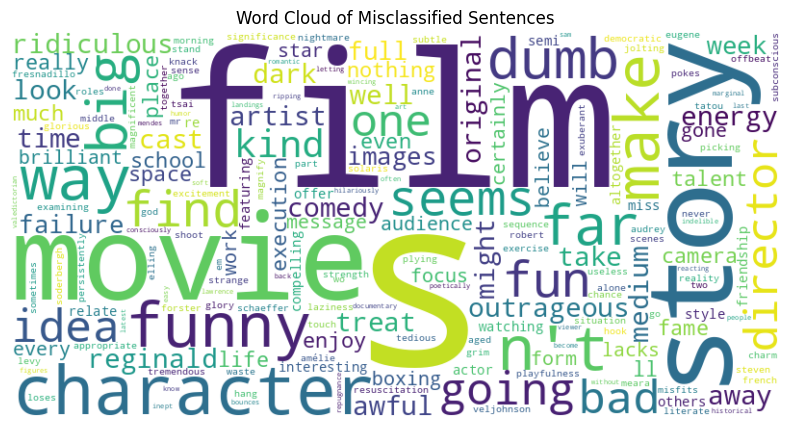

In [ ]:
# Compute and plot confusion matrix
cm = confusion_matrix(eval_labels, eval_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute detailed metrics
precision, recall, f1, _ = precision_recall_fscore_support(eval_labels, eval_preds, average=None)
accuracy = accuracy_score(eval_labels, eval_preds)

print("\nDetailed Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Error analysis
errors = eval_labels != eval_preds
error_indices = np.where(errors)[0]

print("\nError Analysis:")
print(f"Total errors: {np.sum(errors)}")


# Learning curve
def plot_learning_curve(trainer):
    train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(range(0, len(eval_losses) * len(train_losses), len(train_losses)), eval_losses, label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

plot_learning_curve(trainer)

# Word cloud of misclassified sentences
from wordcloud import WordCloud

misclassified_sentences = [dataset['validation'][int(idx)]['sentence'] for idx in error_indices]
misclassified_text = ' '.join(misclassified_sentences)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(misclassified_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Misclassified Sentences')
plt.show()